In [481]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [482]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date')

In [483]:
df.index.dtype

dtype('<M8[ns]')

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

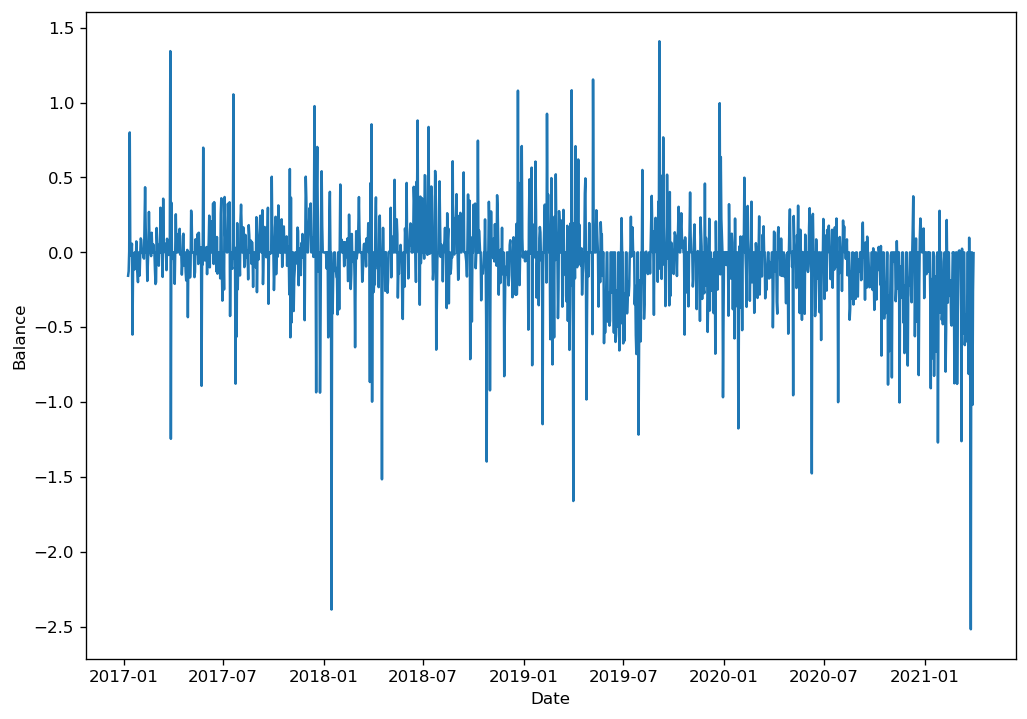

In [484]:
sns.lineplot(x = df.index, y = df.Balance)


# Тест Дики-Фуллера для проверки на стационарность

In [485]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [486]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [487]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [488]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Разложение на компоненты (попытка)

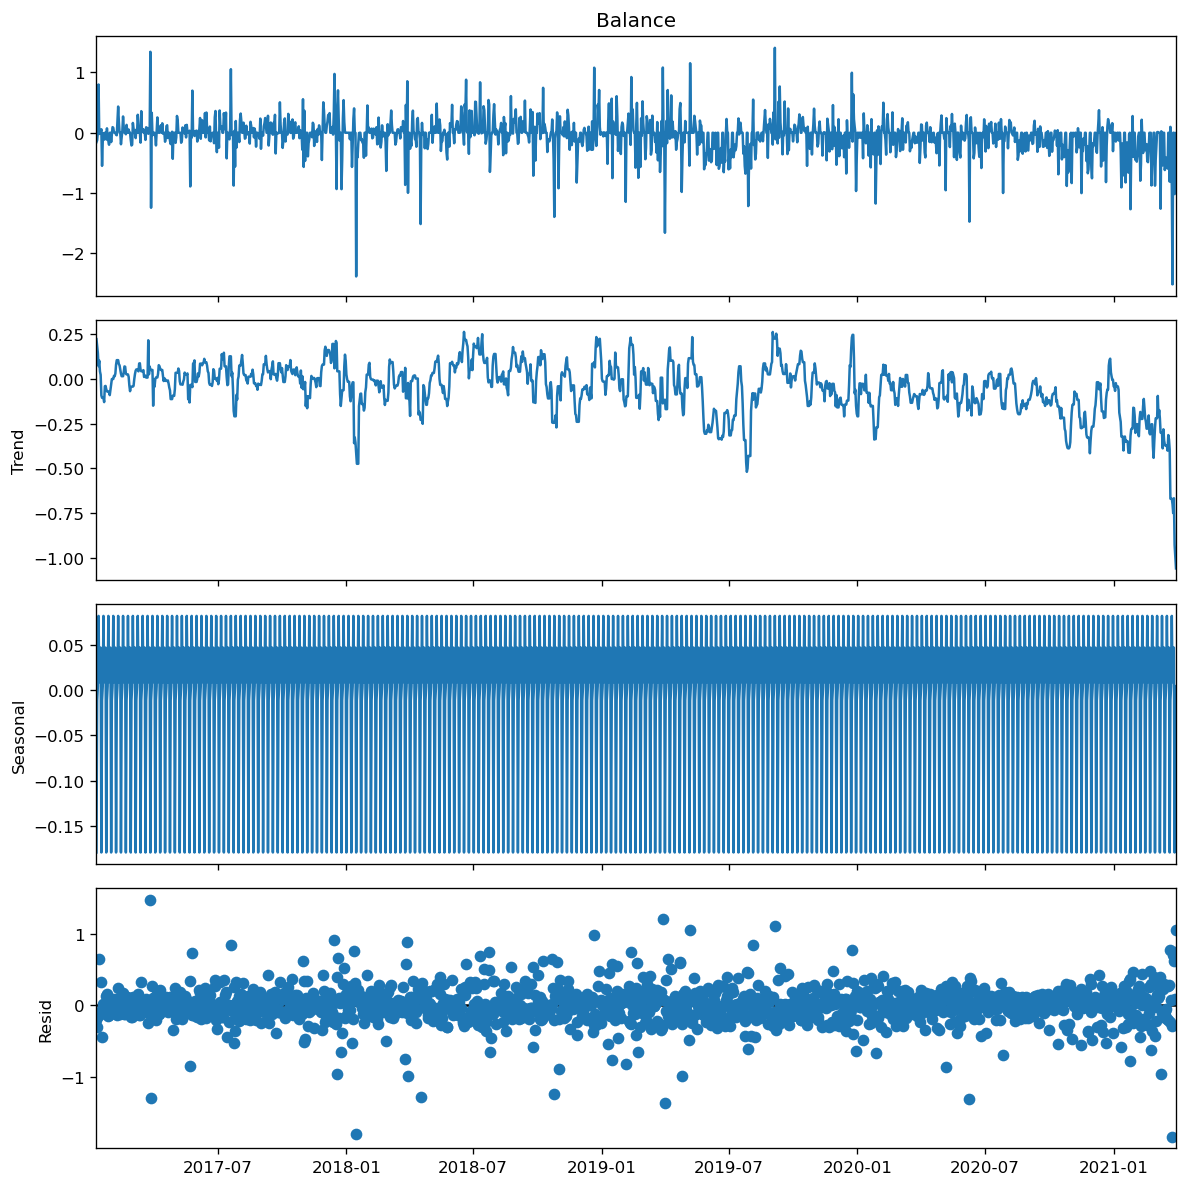

In [489]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Изучение ACF/PACF

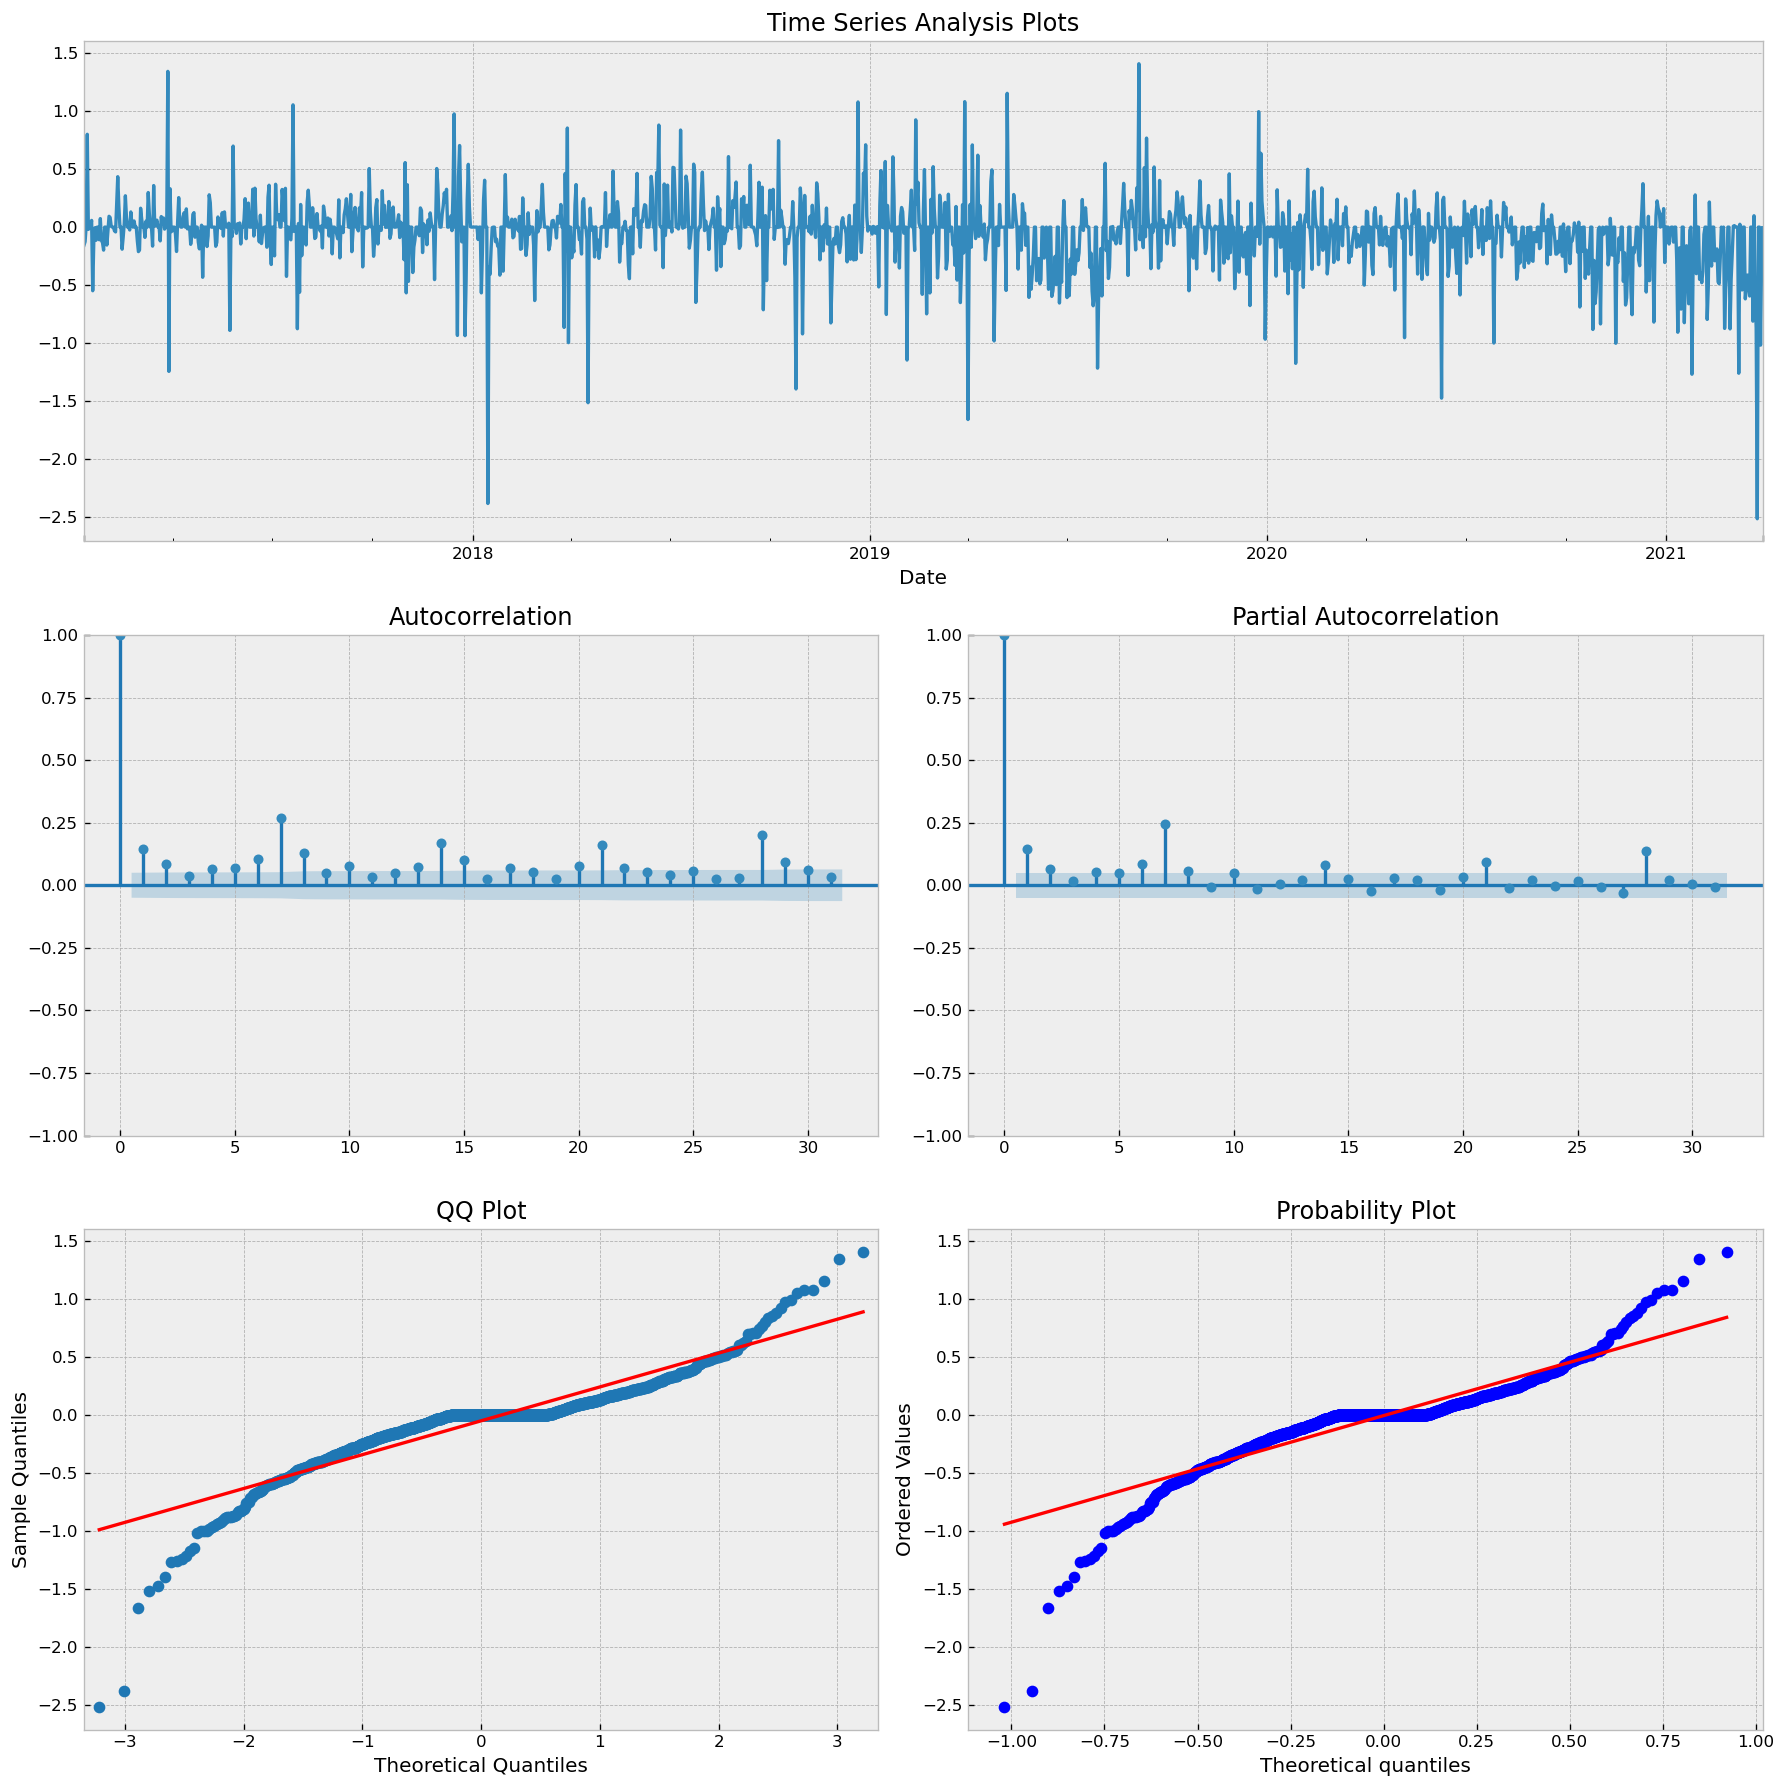

In [490]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
tsplot(df.Balance, lags=31)

## Похоже на AR(1) с сезонностью 7 SARIMA(p=1, q=0, i=0, P=7, Q=0)

Попробуем избавиться от сезонности дифференцированием

In [491]:
# seasonality = 7

# df.Balance = df.Balance - df.Balance.shift(7)
# df = df[7:]

In [492]:
# result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# # Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot()
# plt.show()

In [493]:
# tsplot(df.Balance, lags=31)

# Моделирование

In [494]:
start_date = np.datetime64('2017-06-30')
threshold_date = np.datetime64('2019-07-30')
end_date = np.datetime64('2020-07-30')

In [502]:
from statsmodels.tsa.arima.model import ARIMA

model_SARIMAX = ARIMA(endog=df['Balance'], order=(1, 0, 0), seasonal_order=(1,0, 0, 7))

In [503]:
model_SARIMAX = model_SARIMAX.fit(df.Balance[df.index < start_date])

LinAlgError: Schur decomposition solver error.

In [ ]:
# model_SARIMAX.exog_names[:] = [""]
# model_SARIMAX.summary()

In [ ]:
predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
predict

2019-07-30   -0.203956
2019-07-31   -0.235215
2019-08-01   -0.242872
2019-08-02   -0.191481
2019-08-03   -0.075532
                ...   
2020-07-26   -0.032668
2020-07-27   -0.063726
2020-07-28   -0.082857
2020-07-29   -0.045112
2020-07-30   -0.073625
Freq: D, Name: predicted_mean, Length: 367, dtype: float64

In [ ]:
mask = (df.index >= threshold_date) & (df.index <= end_date)

<Axes: xlabel='Date', ylabel='predicted_mean'>

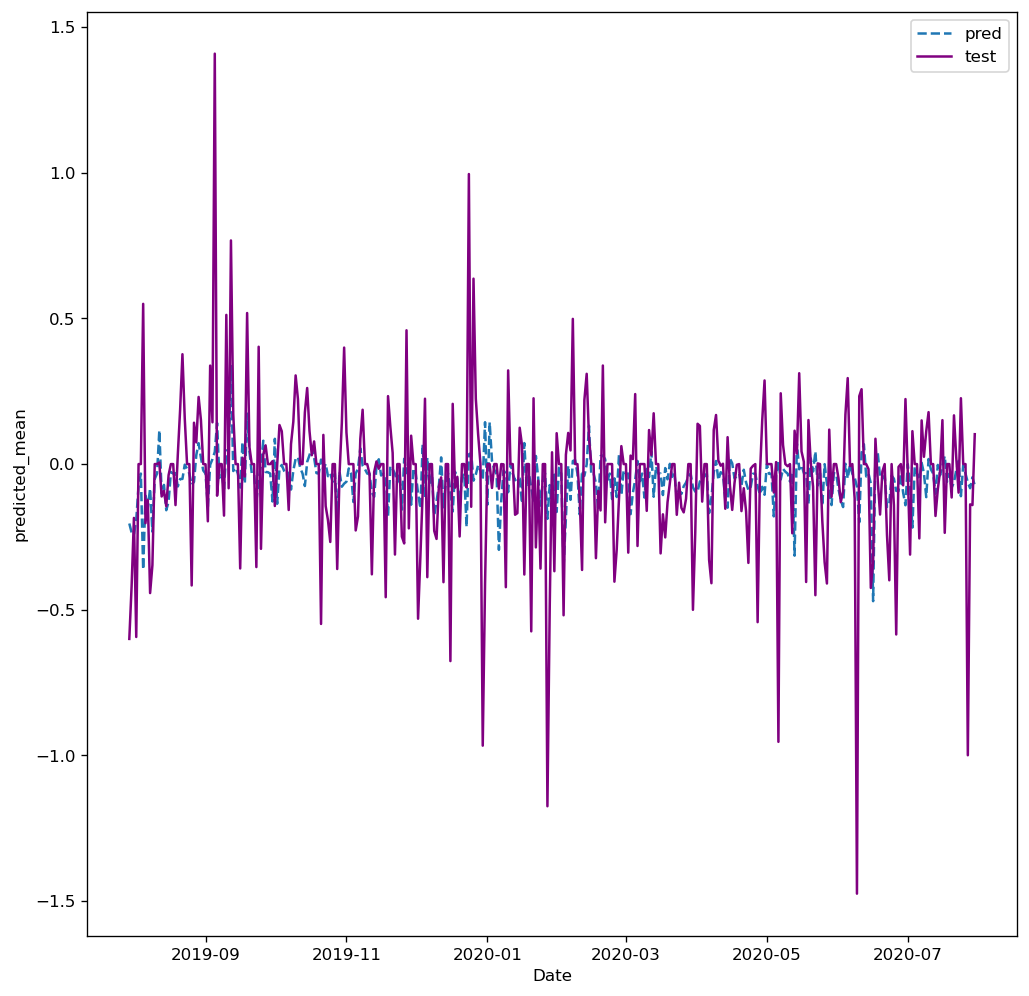

In [ ]:
# sns.lineplot(y=df.Balance[df.index < threshold_date], x=df.index[df.index < threshold_date], label='train')
sns.lineplot(x=df.index[mask], y=predict, label='pred', linestyle='dashed')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date'>

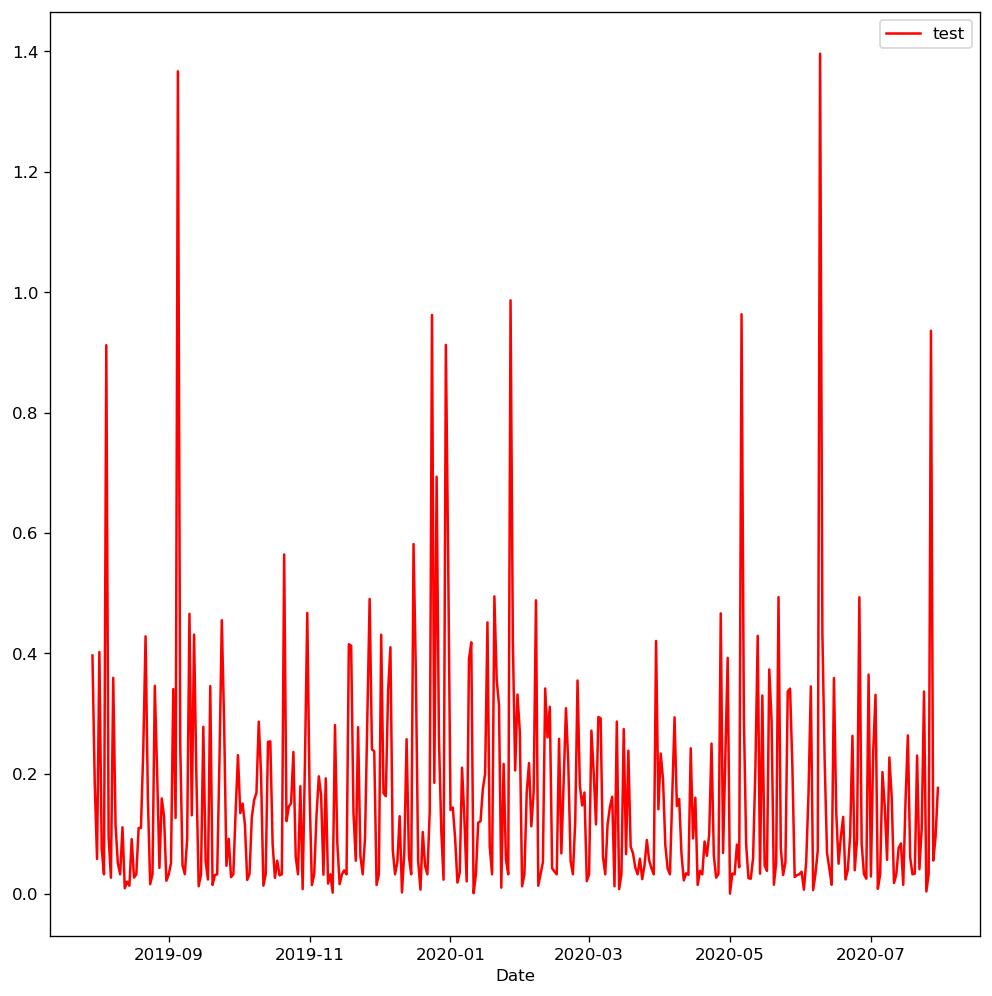

In [ ]:
sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict).abs(), label='test', color = 'red')